In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.autograd as ag
from utils import mnist_reader
import MNISTtools
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import data_split
import gc
from utils import utils
import copy

In [2]:
# Data transforms and augmentation 
train_transform = transforms.Compose([transforms.Resize(224), 
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), 
                                      transforms.Lambda(lambda x: torch.cat([x,x,x],0)) ])

test_transform = transforms.Compose([ transforms.Resize(224), 
                                     transforms.ToTensor(), transforms.Lambda(lambda x: torch.cat([x,x,x],0)) ])

In [3]:
# print('Downloading/Checking for data......')
trainset = torchvision.datasets.FashionMNIST(root='data/downloads', train=True,
                                        download=True, transform=train_transform)       # download=True for the 1st time
testset = torchvision.datasets.FashionMNIST(root='data/downloads', train=False,
                                        download=True, transform=test_transform)        # download=True for the 1st time
train, validation = data_split.train_valid_split(trainset)    # separates 10% for validation

In [15]:
batch_size = 40

In [16]:
trainloader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validation, batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False, num_workers=2)

In [17]:
print('# of batches in training: ',len(trainloader), ',   Total train data: ',len(trainloader)*batch_size)
print('# of batches in test: ',len(testloader), ',   Total test data: ',len(testloader)*batch_size)


# of batches in training:  1350 ,   Total train data:  54000
# of batches in test:  250 ,   Total test data:  10000


# Loading VGG16 (Batch Normalization) trained on imagenet

In [55]:
model = torchvision.models.vgg16_bn(pretrained='imagenet')

#--------------------------------------------------------------------------------------
# REMEMBER: vgg16.features --> convolutional layers, vgg16.classifier --> FC layers
#--------------------------------------------------------------------------------------

# freeze all parameters in covolutional layers
for parameter in model.features.parameters():
    parameter.require_grad = False

in_ftrs = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]       # Removing last layer to add out 10 units layer
    
features.extend([nn.Linear(in_ftrs, 10)])                # adding out layer with 10 units
model.classifier = nn.Sequential(*features)             # replacing it with the model with new last layer

# Loading  Resnet18 trained on imagenet


In [18]:
model = torchvision.models.resnet18(pretrained='imagenet')

in_ftrs = model.fc.in_features

num_ftrs = model.fc.in_features

# adding out layer with 10 units
model.fc = nn.Linear(num_ftrs, 10)


In [19]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [20]:
model = model.cuda()

In [21]:
def test(model, dataloader, compute_loss=False, criterion=None):
    correct = 0
    total = 0
    acc_test = 0.0
    total_loss = 0.0
    
    model.train(False)
    model.eval()    
    for i,data in enumerate(dataloader):
        images, labels = data

        images = images.cuda()
        labels = labels.cuda()

        images = ag.Variable(images, volatile=True)
        labels = ag.Variable(labels, volatile=True)

        outputs = model(images)
        
        if compute_loss:
            loss = criterion(outputs, labels)
            total_loss += loss.data[0]
        
        _, predicted = torch.max(outputs.data, 1)
        acc_test += torch.sum(predicted == labels.data)
        total += len(labels.data)
        del outputs, predicted, images, labels
        torch.cuda.empty_cache()
   
    return acc_test*1.0/total, total_loss*1.0/total

In [11]:
test(model,testloader)

(0.17, 0.0)

In [22]:
def to_file(valid_accs, train_loss_list, valid_loss_list, epoch, best_epoch):
    utils.write_list_to_file('assets/validation_accuracies.txt', valid_accs)
    utils.write_list_to_file('assets/train_loss_list_epoch_'+str(epoch)+'.txt', train_loss_list)
    utils.write_list_to_file('assets/validation_losses.txt', valid_loss_list)
    utils.write_list_to_file('assets/best_epoch.txt', [best_epoch])

# Training the model

In [23]:
model.train(True)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [24]:
start=time.time()
best_acc=0.0
best_model=None
best_epoch=1
valid_accs=[]
valid_loss_list=[]
loss_list = []

for epoch in range(25):  # loop over the dataset multiple times
    model.train(True)
    running_loss = 0.0
    train_loss_list=[]
    
    for i, data in enumerate(trainloader, 0):       # 0 is just to start i from 0
        
        # 10% of the dataset 
        if(i> len(trainloader)/10):
            break

        # get the inputs
        inputs, labels = data
        
        inputs = ag.Variable(inputs, requires_grad = False)
        labels = ag.Variable(labels, requires_grad = False)
        
        # transformations
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss
        train_loss_list.append(loss)
        
        del inputs, labels, loss, outputs
        torch.cuda.empty_cache()
        
    valid_acc, avg_valid_loss=test(model, validloader,True, criterion)
    valid_accs.append(valid_acc)
    valid_loss_list.append(avg_valid_loss)
    
    if valid_acc > best_acc:                                          # check for best model
        best_acc = valid_acc
        best_model = copy.deepcopy(model.state_dict())
        best_epoch = epoch+1
        torch.save(best_model, 'assets/Resnet_best_model.pt')      # save best model
        
    to_file(valid_accs, train_loss_list, valid_loss_list, epoch+1, best_epoch)
    loss_list+=train_loss_list
    
    print('epoch: ', epoch+1)
    print('valid acc: ', valid_acc)
    print('Total time taken in training (secs): ',time.time()-start)

print('Finished Training')

epoch:  1
valid acc:  0.6785
Total time taken in training (secs):  72.7309889793
epoch:  2
valid acc:  0.724833333333
Total time taken in training (secs):  144.700852156
epoch:  3
valid acc:  0.747666666667
Total time taken in training (secs):  217.10985899
epoch:  4
valid acc:  0.769666666667
Total time taken in training (secs):  289.387372017
epoch:  5
valid acc:  0.7755
Total time taken in training (secs):  363.025156975
epoch:  6
valid acc:  0.785
Total time taken in training (secs):  435.338663101
epoch:  7
valid acc:  0.790666666667
Total time taken in training (secs):  507.559953928
epoch:  8
valid acc:  0.7905
Total time taken in training (secs):  579.053056002
epoch:  9
valid acc:  0.808333333333
Total time taken in training (secs):  650.862923145
epoch:  10
valid acc:  0.789666666667
Total time taken in training (secs):  722.949348927
epoch:  11
valid acc:  0.816
Total time taken in training (secs):  795.95036602
epoch:  12
valid acc:  0.821333333333
Total time taken in train

# Saving the model (very important)

In [86]:
torch.save(model.state_dict(), 'ResNet_10%.pt')

In [87]:
torch.cuda.empty_cache()

# Load the saved model
To load a saved model and test it on the test set

In [6]:
# load the architecture's skeleton for VGG-16

model = torchvision.models.vgg16_bn(pretrained=False)
for parameter in model.features.parameters():
    parameter.require_grad = False

in_ftrs = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]       # Removing last layer to add out 10 units layer
features.extend([nn.Linear(in_ftrs, 10)])                # adding out layer with 10 units
model.classifier = nn.Sequential(*features)

In [88]:
# load the architecture's skeleton for Resnet-18

model = torchvision.models.resnet18(pretrained=False)
in_ftrs = model.fc.in_features
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)


In [105]:
# # load the saved model
model.load_state_dict(torch.load('ResNet_10%.pt'))
model = model.cuda()

In [106]:
test(model, testloader)

(0.9033, 0.0)

## Plotting Validation Loss/ Training Loss/ Validation Accuracy

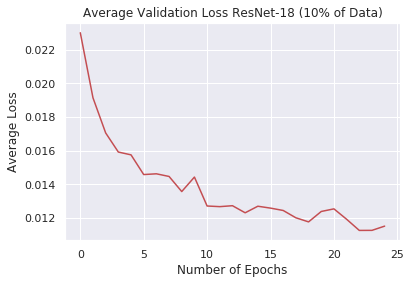

In [100]:
import seaborn as sns
sns.set()

list_temp = []
for i in range(len(loss_list)):
    list_temp.append(loss_list[i].data.cpu().numpy())
    

avg_list = []
for i in range(1,len(list_temp)):
    avg_list.append(sum(list_temp[:i])/(1.0*len(list_temp[:i])))

plt.plot(range(len(valid_loss_list)),valid_loss_list, 'r')
plt.xlabel("Number of Epochs")
plt.ylabel("Average Loss")
plt.title("Average Validation Loss ResNet-18 (10% of Data)")
plt.show()


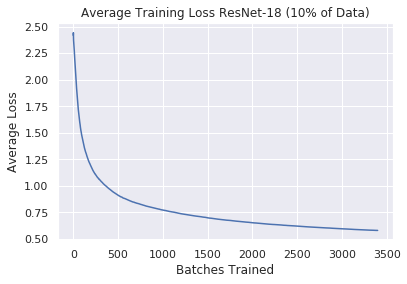

In [101]:

plt.plot(range(len(avg_list)),avg_list)
plt.xlabel("Batches Trained")
plt.ylabel("Average Loss")
plt.title("Average Training Loss ResNet-18 (10% of Data)")
plt.show()

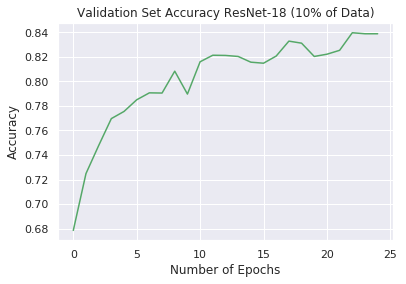

In [31]:
plt.plot(range(len(valid_accs)),valid_accs, 'g')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Set Accuracy ResNet-18 (10% of Data)")
plt.show()